In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as osp
import sys

if "src" not in sys.path:
    sys.path.insert(0, "src")

In [3]:
import numpy as onp
import dill
from easydict import EasyDict as edict
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

import jax
from jax import numpy as jnp, random
from jax.random import PRNGKey, split

import haiku as hk
import optax as ox

from train_mrcl_rebuilt import get_dataset, OMLConvnet, ANMLNet, BatchSampler

/home/samenabar/storage/.pyenv/versions/3.7.8/envs/378/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [5]:
def get_test_slow_params_sup(params, w_name):
    return hk.data_structures.partition(
        lambda module_name, name, value: w_name in module_name,
        params,
    )[1]

def get_test_fast_params_sup(
    rng,
    params,
    w_name,
    zero_weight=True,
    keep_bias=False,
):
    tmp_fast_params = hk.data_structures.partition(
        lambda module_name, name, value: w_name in module_name,
        params,
    )[0]

    weights, biases = hk.data_structures.partition(
        lambda module_name, name, value: name == "w", tmp_fast_params
    )
    tmp_fast_params = hk.data_structures.merge(
        jax.tree_map(lambda t: jnp.zeros_like(t), weights)
        if zero_weight
        else jax.tree_map(lambda t: reset_fn(dtype=t.dtype)(rng, t.shape), weights),
        biases if keep_bias else jax.tree_map(lambda t: jnp.zeros_like(t), biases),
    )
    return tmp_fast_params


def get_test_slow_params_anml(slow_params, fast_params=None):
    return hk.data_structures.merge(
        slow_params,
        hk.data_structures.partition(
            lambda module_name, name, value: "classifier" in module_name,
            fast_params,
        )[1],
    )

def get_test_fast_params_anml(
    rng,
    fast_params,
    zero_weight=False,
    keep_bias=True,
):
    tmp_fast_params = hk.data_structures.partition(
        lambda module_name, name, value: "classifier" in module_name,
        fast_params,
    )[0]

    weights, biases = hk.data_structures.partition(
        lambda module_name, name, value: name == "w", tmp_fast_params
    )
    tmp_fast_params = hk.data_structures.merge(
        jax.tree_map(lambda t: jnp.zeros_like(t), weights)
        if zero_weight
        else jax.tree_map(
            lambda t: reset_fn(dtype=t.dtype)(rng, t.shape), weights
        ),
        biases
        if keep_bias
        else jax.tree_map(lambda t: jnp.zeros_like(t), biases),
    )
    return tmp_fast_params


def get_test_slow_params_oml(slow_params, fast_params=None):
    return slow_params

def get_test_fast_params_oml(rng, fast_params, zero_weight=False, keep_bias=False):
    tmp_fast_params = fast_params
    weights, biases = hk.data_structures.partition(
        lambda module_name, name, value: name == "w", tmp_fast_params
    )
    tmp_fast_params = hk.data_structures.merge(
        jax.tree_map(lambda t: jnp.zeros_like(t), weights)
        if zero_weight
        else jax.tree_map(
            lambda t: reset_fn(dtype=t.dtype)(rng, t.shape), weights
        ),
        biases
        if keep_bias
        else jax.tree_map(lambda t: jnp.zeros_like(t), biases),
    )
    return tmp_fast_params


get_test_fast_params = {
    "sup": get_test_fast_params_sup,
    "oml": get_test_fast_params_oml,
    "anml": get_test_fast_params_anml,
}

get_test_slow_params = {
    "sup": get_test_slow_params_sup,
    "oml": get_test_slow_params_oml,
    "anml": get_test_slow_params_anml,
}

In [7]:
dataset_name = "omniglot"
data_dir = "../data/from_torch/omniglot/"

train_dataset_28 = get_dataset(
    dataset_name, "train+val", train=True, all=True, image_size=28, data_dir=data_dir,
)
train_dataset_84 = get_dataset(
    dataset_name, "train+val", train=True, all=True, image_size=84, data_dir=data_dir,
)

test_dataset_28 = get_dataset(
    dataset_name, "test_train", train=False, all=True, image_size=28, data_dir=data_dir,
)
test_dataset_84 = get_dataset(
    dataset_name, "test_train", train=False, all=True, image_size=84, data_dir=data_dir,
)

dataloader28 = BatchSampler(
    None,
    test_dataset_28,
    batch_size=256,
    shuffle=False,
    keep_last=True,
    dataset_is_array=True,
)
dataloader84 = BatchSampler(
    None,
    test_dataset_84,
    batch_size=256,
    shuffle=False,
    keep_last=True,
    dataset_is_array=True,
)

In [8]:
train_dataset_28 = get_dataset(
    dataset_name, "train+val", train=True, all=True, image_size=28, data_dir=data_dir,
)
train_dataset_84 = get_dataset(
    dataset_name, "train+val", train=True, all=True, image_size=84, data_dir=data_dir,
)

dataloader28_train = BatchSampler(
    None,
    train_dataset_28,
    batch_size=256,
    shuffle=False,
    keep_last=True,
    dataset_is_array=True,
)
dataloader84_train = BatchSampler(
    None,
    train_dataset_84,
    batch_size=256,
    shuffle=False,
    keep_last=True,
    dataset_is_array=True,
)

In [10]:
def load_model(model_dir, is_sup, model_fname="model.dill"):
    with open(osp.join(model_dir, model_fname), "rb") as f:
        ckpt = dill.load(f)
    with open(osp.join(model_dir, "args.json"), "r") as f:
        metadata = edict(json.load(f))
        
    if metadata.model == "anml":
        w_name = "classifier"
        _model = ANMLNet
        data_normalize_fn = train_dataset_28.normalize
    elif metadata.model == "oml":
        w_name = "oml_convnet/linear"
        _model = OMLConvnet
        data_normalize_fn = train_dataset_28.normalize
        
    if is_sup:
        slow_params = get_test_slow_params["sup"](ckpt["params"], w_name)
        fast_params = get_test_fast_params["sup"](None, ckpt["params"], w_name)
        slow_state = ckpt["state"]
        fast_state = ckpt["state"]
    else:
        slow_params = get_test_slow_params[metadata.model](ckpt["slow_params"], ckpt["fast_params"])
        fast_params = get_test_fast_params[metadata.model](None, ckpt["fast_params"], zero_weight=True, keep_bias=False)
        slow_state = ckpt["slow_state"]
        fast_state = ckpt["fast_state"]
        
    model = hk.transform_with_state(
        lambda x, mask=None, phase="all", training=None: _model(
            1000, 9, image_size=metadata.image_size
        )(
            x,
            mask=mask,
            phase=phase,
            training=training,
        )
    )

    if metadata.model == "oml":
        test_encoding_phase = "encoder"
    elif metadata.model == "anml":
        test_encoding_phase = "everything"

    dataset_name = "omniglot"
    # data_normalize_fn = get_dataset(
    #     dataset_name, "train", train=True, all=True, image_size=metadata.image_size
    # ).normalize

    if getattr(metadata, "normalize_input", False):
        normalize_fn = data_normalize_fn
    else:
        normalize_fn = lambda x: x

    extract_embeddings_fn = jax.jit(lambda x: model.apply(
        hk.data_structures.merge(slow_params, fast_params),
        hk.data_structures.merge(slow_state, fast_state),
        None,
        normalize_fn(x / 255),
        phase=test_encoding_phase,
    )[0])
    
    return extract_embeddings_fn

In [11]:
oml_sup_model_dir = "./results/supervised/oml/oml_0/"
oml_sup_model_aug_dir = "./results/supervised/oml/oml_aug_0/"

# oml_model_dir = "./results/final/oml_84_olr-1e-4_attempt0_1/"
# oml_zero_model_dir = "./results/meta/oml_aug/oml_zero_reset_b4_outer_500k_0/"
oml_zero_aug_model_dir = "./results/meta/oml_aug/oml_zero_reset_b4_outer_500k_0/"

oml_sup_model = load_model(oml_sup_model_dir, True)
oml_sup_model_aug = load_model(oml_sup_model_aug_dir, True)

# oml_model = load_model(oml_model_dir, False)
# oml_zero_model = load_model(oml_zero_model_dir, False)
oml_zero_model_aug = load_model(oml_zero_aug_model_dir, False)


# oml_sup_model_dir_2 = "./results/final2/test/supervised/oml_sup_test_2/"
# oml_sup_model_aug_dir_2 = "./results/final2/test/supervised/oml_sup_aug_test_2/"

# oml_model_dir_2 = "./results/final/oml_84_olr-1e-4_attempt0_2/"
# oml_zero_model_dir_2 = "./results/final2/test/oml/oml_zero_reset_b4_outer_2/"
# oml_zero_aug_model_dir_2 = "./results/final2/test/oml/oml_zero_reset_b4_outer_aug-qry_2/"

# oml_sup_model_2 = load_model(oml_sup_model_dir_2, True)
# oml_sup_model_aug_2 = load_model(oml_sup_model_aug_dir_2, True)

# oml_model_2 = load_model(oml_model_dir_2, False)
# oml_zero_model_2 = load_model(oml_zero_model_dir_2, False)
# oml_zero_model_aug_2 = load_model(oml_zero_aug_model_dir_2, False)


# oml_sup_model_dir_3 = "./results/final2/test/supervised/oml_sup_test_3/"
# oml_sup_model_aug_dir_3 = "./results/final2/test/supervised/oml_sup_aug_test_3/"

# oml_model_dir_3 = "./results/final/oml_84_olr-1e-4_attempt0_3/"
# oml_zero_model_dir_3 = "./results/final2/test/oml/oml_zero_reset_b4_outer_3/"
# oml_zero_aug_model_dir_3 = "./results/final2/test/oml/oml_zero_reset_b4_outer_aug-qry_3/"

# oml_sup_model_3 = load_model(oml_sup_model_dir_3, True)
# oml_sup_model_aug_3 = load_model(oml_sup_model_aug_dir_3, True)

# oml_model_3 = load_model(oml_model_dir_3, False)
# oml_zero_model_3 = load_model(oml_zero_model_dir_3, False)
# oml_zero_model_aug_3 = load_model(oml_zero_aug_model_dir_3, False)

In [13]:
anml_sup_model_dir = "./results/supervised/anml/anml_0/"
# anml_sup_model_aug_dir = "./results/meta/anml/anml_zero_25k_aug_all_0/"

# anml_model_dir = "./results/final/anml_28_olr-1e-3_attempt0_1/"
anml_zero_model_dir = "./results/meta/anml/anml_zero_25k_0/"
anml_zero_model_aug_dir = "./results/meta/anml/anml_zero_25k_aug_all_0/"

anml_sup_model = load_model(anml_sup_model_dir, True)
# anml_sup_model_aug = load_model(anml_sup_model_aug_dir, True)

# anml_model = load_model(anml_model_dir, False)
anml_zero_model = load_model(anml_zero_model_dir, False)
anml_zero_model_aug = load_model(anml_zero_model_aug_dir, False)


# anml_sup_model_dir_2 = "./results/final2/test/supervised/anml_sup_test_2/"
# anml_sup_model_aug_dir_2 = "./results/final2/test/supervised/anml_sup_aug_test_2/"

# anml_model_dir_2 = "./results/final/anml_28_olr-1e-3_attempt0_2/"
# anml_zero_model_dir_2 = "./results/final2/test/anml/anml_zero_reset_b4_outer_2/"
# anml_zero_model_aug_dir_2 = "./results/final2/test/anml/anml_zero_reset_b4_outer_aug-all_2/"

# anml_sup_model_2 = load_model(anml_sup_model_dir_2, True)
# anml_sup_model_aug_2 = load_model(anml_sup_model_aug_dir_2, True)

# anml_model_2 = load_model(anml_model_dir_2, False)
# anml_zero_model_2 = load_model(anml_zero_model_dir_2, False)
# anml_zero_model_aug_2 = load_model(anml_zero_model_aug_dir_2, False)


# anml_sup_model_dir_3 = "./results/final2/test/supervised/anml_sup_test_3/"
# anml_sup_model_aug_dir_3 = "./results/final2/test/supervised/anml_sup_aug_test_3/"

# anml_model_dir_3 = "./results/final/anml_28_olr-1e-3_attempt0_3/"
# anml_zero_model_dir_3 = "./results/final2/test/anml/anml_zero_reset_b4_outer_3/"
# anml_zero_model_aug_dir_3 = "./results/final2/test/anml/anml_zero_reset_b4_outer_aug-all_3/"

# anml_sup_model_3 = load_model(anml_sup_model_dir_3, True)
# anml_sup_model_aug_3 = load_model(anml_sup_model_aug_dir_3, True)

# anml_model_3 = load_model(anml_model_dir_3, False)
# anml_zero_model_3 = load_model(anml_zero_model_dir_3, False)
# anml_zero_model_aug_3 = load_model(anml_zero_model_aug_dir_3, False)

In [14]:
def get_sparsity_dead_neurons(reprs, factor, thresh=0.01):
    sp = ((reprs / factor) < thresh).mean()
    dead = (reprs.max(0) == 0).mean()
    
    return sp, dead

def get_factor(reprs):
    factor = reprs.max(0, keepdims=True)
    factor[factor == 0] = 1
    return factor


def extract_reprs(embs_fn, model, train=False):
    all_reprs_raw = []
    all_mask_raw = []
    all_pre_nm_raw = []

    if model == "anml":
        if train:
            dataloader = dataloader28_train
        else:
            dataloader = dataloader28
    else:
        if train:
            dataloader = dataloader84_train
        else:
            dataloader = dataloader84
    
    for x, _ in tqdm(dataloader, total=len(dataloader)):
        outs = embs_fn(x)

        if model == "oml":
            all_reprs_raw.append(jax.device_get(outs[0]))
        elif model == "anml":
            mask, pre_nm, post_nm, preds = jax.tree_map(jax.device_get, outs)
            all_reprs_raw.append(post_nm)
            all_mask_raw.append(mask)
            all_pre_nm_raw.append(pre_nm)

    all_reprs_raw = onp.concatenate(all_reprs_raw, 0)
    if model == "anml":
        all_mask_raw = onp.concatenate(all_mask_raw, 0)
        all_pre_nm_raw = onp.concatenate(all_pre_nm_raw, 0)
        
    return all_reprs_raw, all_mask_raw, all_pre_nm_raw

In [16]:
oml_sup_model_reprs = extract_reprs(oml_sup_model, "oml")
oml_sup_model_aug_reprs = extract_reprs(oml_sup_model_aug, "oml")

# oml_model_reprs = extract_reprs(oml_model, "oml")
# oml_zero_model_reprs = extract_reprs(oml_zero_model, "oml")
oml_zero_model_aug_reprs = extract_reprs(oml_zero_model_aug, "oml")


# oml_sup_model_reprs_2 = extract_reprs(oml_sup_model_2, "oml")
# oml_sup_model_aug_reprs_2 = extract_reprs(oml_sup_model_aug_2, "oml")

# oml_model_reprs_2 = extract_reprs(oml_model_2, "oml")
# oml_zero_model_reprs_2 = extract_reprs(oml_zero_model_2, "oml")
# oml_zero_model_aug_reprs_2 = extract_reprs(oml_zero_model_aug_2, "oml")


# oml_sup_model_reprs_3 = extract_reprs(oml_sup_model_3, "oml")
# oml_sup_model_aug_reprs_3 = extract_reprs(oml_sup_model_aug_3, "oml")

# oml_model_reprs_3 = extract_reprs(oml_model_3, "oml")
# oml_zero_model_reprs_3 = extract_reprs(oml_zero_model_3, "oml")
# oml_zero_model_aug_reprs_3 = extract_reprs(oml_zero_model_aug_3, "oml")

In [17]:
anml_sup_model_reprs = extract_reprs(anml_sup_model, "anml")
# anml_sup_model_aug_reprs = extract_reprs(anml_sup_model_aug, "anml")

# anml_model_reprs = extract_reprs(anml_model, "anml")
anml_zero_model_reprs = extract_reprs(anml_zero_model, "anml")
anml_zero_model_aug_reprs = extract_reprs(anml_zero_model_aug, "anml")


# anml_sup_model_reprs_2 = extract_reprs(anml_sup_model_2, "anml")
# anml_sup_model_aug_reprs_2 = extract_reprs(anml_sup_model_aug_2, "anml")

# anml_model_reprs_2 = extract_reprs(anml_model_2, "anml")
# anml_zero_model_reprs_2 = extract_reprs(anml_zero_model_2, "anml")
# anml_zero_model_aug_reprs_2 = extract_reprs(anml_zero_model_aug_2, "anml")


# anml_sup_model_reprs_3 = extract_reprs(anml_sup_model_3, "anml")
# anml_sup_model_aug_reprs_3 = extract_reprs(anml_sup_model_aug_3, "anml")

# anml_model_reprs_3 = extract_reprs(anml_model_3, "anml")
# anml_zero_model_reprs_3 = extract_reprs(anml_zero_model_3, "anml")
# anml_zero_model_aug_reprs_3 = extract_reprs(anml_zero_model_aug_3, "anml")

In [18]:
oml_sup_model_reprs_train = extract_reprs(oml_sup_model, "oml", train=True)
oml_sup_model_aug_reprs_train = extract_reprs(oml_sup_model_aug, "oml", train=True)

anml_sup_model_reprs_train = extract_reprs(anml_sup_model, "anml", train=True)
# anml_sup_model_aug_reprs_train = extract_reprs(anml_sup_model_aug, "anml", train=True)

# oml_model_reprs_train = extract_reprs(oml_model, "oml", train=True)
# oml_zero_model_reprs_train = extract_reprs(oml_zero_model, "oml", train=True)
oml_zero_model_aug_reprs_train = extract_reprs(oml_zero_model_aug, "oml", train=True)

# anml_model_reprs_train = extract_reprs(anml_model, "anml", train=True)
anml_zero_model_reprs_train = extract_reprs(anml_zero_model, "anml", train=True)
anml_zero_model_aug_reprs_train = extract_reprs(anml_zero_model_aug, "anml", train=True)

# oml_sup_model_reprs_train_2 = extract_reprs(oml_sup_model_2, "oml", train=True)
# oml_sup_model_aug_reprs_train_2 = extract_reprs(oml_sup_model_aug_2, "oml", train=True)

# anml_sup_model_reprs_train_2 = extract_reprs(anml_sup_model_2, "anml", train=True)
# anml_sup_model_aug_reprs_train_2 = extract_reprs(anml_sup_model_aug_2, "anml", train=True)

# oml_model_reprs_train_2 = extract_reprs(oml_model_2, "oml", train=True)
# oml_zero_model_reprs_train_2 = extract_reprs(oml_zero_model_2, "oml", train=True)
# oml_zero_model_aug_reprs_train_2 = extract_reprs(oml_zero_model_aug_2, "oml", train=True)

# anml_model_reprs_train_2 = extract_reprs(anml_model_2, "anml", train=True)
# anml_zero_model_reprs_train_2 = extract_reprs(anml_zero_model_2, "anml", train=True)
# anml_zero_model_aug_reprs_train_2 = extract_reprs(anml_zero_model_aug_2, "anml", train=True)

# oml_sup_model_reprs_train_3 = extract_reprs(oml_sup_model_3, "oml", train=True)
# oml_sup_model_aug_reprs_train_3 = extract_reprs(oml_sup_model_aug_3, "oml", train=True)

# anml_sup_model_reprs_train_3 = extract_reprs(anml_sup_model_3, "anml", train=True)
# anml_sup_model_aug_reprs_train_3 = extract_reprs(anml_sup_model_aug_3, "anml", train=True)

# oml_model_reprs_train_3 = extract_reprs(oml_model_3, "oml", train=True)
# oml_zero_model_reprs_train_3 = extract_reprs(oml_zero_model_3, "oml", train=True)
# oml_zero_model_aug_reprs_train_3 = extract_reprs(oml_zero_model_aug_3, "oml", train=True)

# anml_model_reprs_train_3 = extract_reprs(anml_model_3, "anml", train=True)
# anml_zero_model_reprs_train_3 = extract_reprs(anml_zero_model_3, "anml", train=True)
# anml_zero_model_aug_reprs_train_3 = extract_reprs(anml_zero_model_aug_3, "anml", train=True)

In [19]:
def get_all(model_dir, is_sup, model_name):
    model = load_model(model_dir, is_sup)
    train_reprs = extract_reprs(model, model_name, train=True)
    test_reprs = extract_reprs(model, model_name)
    
    train_sp, train_dn = get_sparsity_dead_neurons(
        train_reprs[0], get_factor(train_reprs[0])
    )
    test_sp, test_dn = get_sparsity_dead_neurons(
        test_reprs[0], get_factor(train_reprs[0])
    )
    
    return train_sp, train_dn, test_sp, test_dn

In [20]:
print("OML TSL no aug")

# for i in range(1, 4):
print(
    get_all(
        # f"./results/final2/test/supervised/oml_sup_test_{i}/",
        "results/supervised/oml/oml_0/",
        is_sup=True,
        model_name="oml",
    )
)

print("OML TSL aug")

# for i in range(1, 4):
print(
    get_all(
        # f"./results/final2/test/supervised/oml_sup_aug_test_{i}/",
        "results/supervised/oml/oml_aug_0/",
        is_sup=True,
        model_name="oml",
    )
)

print("ANML TSL")

# for i in range(1, 4):
print(
    get_all(
        # f"./results/final2/test/supervised/anml_sup_test_{i}/",
        "results/supervised/anml/anml_0/",
        is_sup=True,
        model_name="anml",
    )
)

# print("ANML TSL aug")

# for i in range(1, 4):
#     print(
#         get_all(
#             f"./results/final2/test/supervised/anml_sup_aug_test_{i}/",
#             is_sup=True,
#             model_name="anml",
#         )
#     )

OML TSL no aug



(0.9208332207742623, 0.01171875, 0.9182162907287978, 0.011284722222222222)
OML TSL aug



(0.887947107141828, 0.013888888888888888, 0.8801661819254764, 0.015190972222222222)
ANML TSL



(0.3278082137505763, 0.0, 0.32373430518673074, 0.0)


In [21]:
# print("OML no aug")

# for i in range(1, 4):
#     print(
#         get_all(
#             f"./results/final/oml_84_olr-1e-4_attempt0_{i}/",
#             is_sup=False,
#             model_name="oml",
#         )
#     )

# print("OML ZI")

# for i in range(1, 4):
#     print(
#         get_all(
#             f"./results/final2/test/oml/oml_zero_reset_b4_outer_{i}/",
#             is_sup=False,
#             model_name="oml",
#         )
#     )
    
print("OML ZI Aug")

# for i in range(1, 4):
print(
    get_all(
        # f"./results/final2/test/oml/oml_zero_reset_b4_outer_aug-qry_{i}/",
        "results/meta/oml_aug/oml_zero_reset_b4_outer_500k_0/",
        is_sup=False,
        model_name="oml",
    )
)

# print("ANML")

# for i in range(1, 4):
#     print(
#         get_all(
#             f"./results/final/anml_28_olr-1e-3_attempt0_{i}/",
#             is_sup=False,
#             model_name="anml",
#         )
#     )

print("ANML ZI")

# for i in range(1, 4):
print(
    get_all(
        # f"./results/final2/test/anml/anml_zero_reset_b4_outer_{i}/",
        "results/meta/anml/anml_zero_25k_0/",
        is_sup=False,
        model_name="anml",
    )
)
    
print("ANML ZI Aug")

# for i in range(1, 4):
print(
    get_all(
        # f"./results/final2/test/anml/anml_zero_reset_b4_outer_aug-all_{i}/",
        "results/meta/anml/anml_zero_25k_aug_all_0/",
        is_sup=False,
        model_name="anml",
    )
)

OML ZI Aug



(0.917326668035385, 0.1467013888888889, 0.9200773083164727, 0.14930555555555555)
ANML ZI



(0.9362278123559243, 0.0, 0.9370915594440229, 0.0)
ANML ZI Aug



(0.9510560517159405, 0.0, 0.9527627613387287, 0.0)


[11923, 9924, 10183]


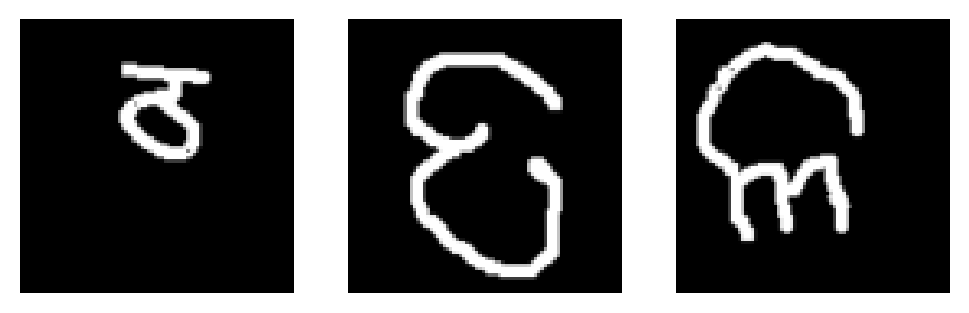

In [22]:
# random_indexes = random.choice(PRNGKey(0), jnp.arange(len(test_dataset)), (3,), replace=False)
random_indexes = [11923,  9924, 10183]
print(random_indexes)
sampled_images, sampled_labels = test_dataset_84[list(random_indexes)]

fig, axes = plt.subplots(ncols=3)

for im, ax in zip(sampled_images, axes):
    ax.imshow(im, cmap="binary")
    ax.set_axis_off()

In [24]:
sampled_images, sampled_labels = test_dataset_84[list(random_indexes)]
# outs = extract_embeddings_fn(sampled_images)
    
# oml_sample_reprs = (jax.device_get(oml_model(sampled_images)[0]))
# oml_zero_sample_reprs = (jax.device_get(oml_zero_model(sampled_images)[0]))
oml_zero_aug_sample_reprs = (jax.device_get(oml_zero_model_aug(sampled_images)[0]))

oml_sup_sample_reprs = (jax.device_get(oml_sup_model(sampled_images)[0]))
oml_sup_aug_sample_reprs = (jax.device_get(oml_sup_model_aug(sampled_images)[0]))

# oml_sample_reprs_2 = (jax.device_get(oml_model_2(sampled_images)[0]))
# oml_zero_sample_reprs_2 = (jax.device_get(oml_zero_model_2(sampled_images)[0]))
# oml_zero_aug_sample_reprs_2 = (jax.device_get(oml_zero_model_aug_2(sampled_images)[0]))

# oml_sup_sample_reprs_2 = (jax.device_get(oml_sup_model_2(sampled_images)[0]))
# oml_sup_aug_sample_reprs_2 = (jax.device_get(oml_sup_model_aug_2(sampled_images)[0]))

# oml_sample_reprs_3 = (jax.device_get(oml_model_3(sampled_images)[0]))
# oml_zero_sample_reprs_3 = (jax.device_get(oml_zero_model_3(sampled_images)[0]))
# oml_zero_aug_sample_reprs_3 = (jax.device_get(oml_zero_model_aug_3(sampled_images)[0]))

# oml_sup_sample_reprs_3 = (jax.device_get(oml_sup_model_3(sampled_images)[0]))
# oml_sup_aug_sample_reprs_3 = (jax.device_get(oml_sup_model_aug_3(sampled_images)[0]))

In [25]:
def get_act_map(reprs):
    # maxes = reprs.max(0, keepdims=True)
    # maxes[maxes == 0] = 1
    # return (reprs / maxes).mean(0).reshape(32, 72)
    return (reprs > 0).astype(onp.int).mean(0).reshape(32, 72)

In [26]:
import matplotlib as mpl

Text(0.5, 1.0, 'Mean activation')

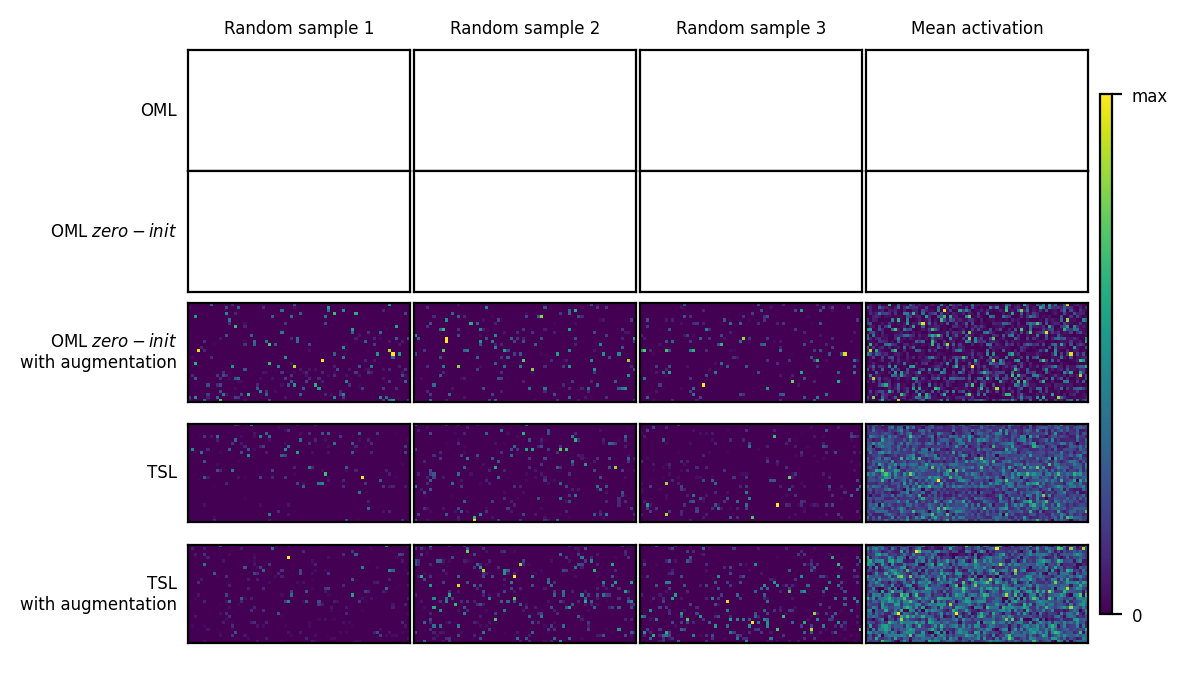

In [41]:
fig, axes = plt.subplots(
    ncols=4,
    nrows=5,
)
(ax_reimpl, ax_reimpl_zero, ax_reimpl_zero_aug, ax_tsl, ax_tsl_aug) = axes[:, -1]

# [(ax.set_axis_off()) for ax in axes.ravel()]
[(ax.set_yticks([]), ax.set_xticks([])) for ax in axes.ravel()]

all_list = [
        # (oml_model_reprs, oml_sample_reprs),
        None,
        # (oml_zero_model_reprs, oml_zero_sample_reprs),
        None,
        (oml_zero_model_aug_reprs, oml_zero_aug_sample_reprs),
        (oml_sup_model_reprs, oml_sup_sample_reprs),
        (oml_sup_model_aug_reprs, oml_sup_aug_sample_reprs),
    ]

for i in range(2, 5):
    (all_reprs, s_reprs) = all_list[i]
    for j in range(3):
        ax = axes[i, j]
        s_repr = s_reprs[j]
        # factor = all_reprs[0].max(0, keepdims=True)
        # factor[factor == 0] = 1
        factor = s_repr.max()
        ax.imshow((s_repr / factor).reshape(32, 72))
        # ax.imshow((s_repr > 0).astype(onp.int).reshape(32, 72))
    im = axes[i, -1].imshow(get_act_map(all_reprs[0]))

plt.subplots_adjust(
    # bottom=0.1,
    left=0.15,
    # top=0.9,
    # right=0.8,
    wspace=0.02,
    hspace=0.00,
)

cb_ax = fig.add_axes([0.91, 0.175, 0.01, 0.65])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)

for ax, title in zip(
    axes[:, 0],
    [
        "OML",
        "OML $\it{zero-init}$",
        "OML $\it{zero-init}$\nwith augmentation",
        "TSL",
        "TSL\nwith augmentation",
    ],
):
    ax.set_ylabel(
        title,
        rotation=0,
        fontsize=6,
        labelpad=4,
        verticalalignment="center",
        horizontalalignment="right",
    )

for ax, i in zip(axes[0, :], range(1, 4)):
    ax.set_title(f"Random sample {i}", fontsize=6)

axes[0, -1].set_title("Mean activation", fontsize=6)

# plt.tight_layout()
# plt.savefig("oml_reprs.jpg", dpi=300)

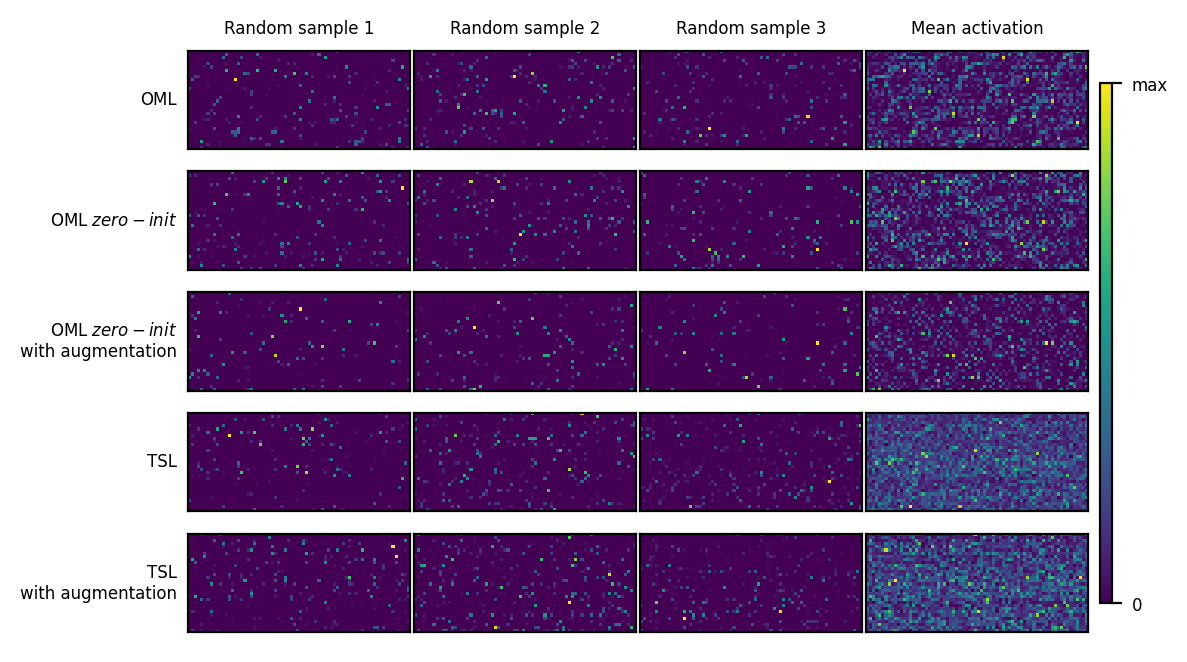

In [17]:
# fig, axes = plt.subplots(
#     ncols=4,
#     nrows=5,
# )
# (ax_reimpl, ax_reimpl_zero, ax_reimpl_zero_aug, ax_tsl, ax_tsl_aug) = axes[:, -1]

# # [(ax.set_axis_off()) for ax in axes.ravel()]
# [(ax.set_yticks([]), ax.set_xticks([])) for ax in axes.ravel()]


# for i, (all_reprs, s_reprs) in enumerate(
#     [
#         (oml_model_reprs_2, oml_sample_reprs_2),
#         (oml_zero_model_reprs_2, oml_zero_sample_reprs_2),
#         (oml_zero_model_aug_reprs_2, oml_zero_aug_sample_reprs_2),
#         (oml_sup_model_reprs_2, oml_sup_sample_reprs_2),
#         (oml_sup_model_aug_reprs_2, oml_sup_aug_sample_reprs_2),
#     ]
# ):
#     for j in range(3):
#         ax = axes[i, j]
#         s_repr = s_reprs[j]
#         # factor = all_reprs[0].max(0, keepdims=True)
#         # factor[factor == 0] = 1
#         factor = s_repr.max()
#         ax.imshow((s_repr / factor).reshape(32, 72))
#         # ax.imshow((s_repr > 0).astype(onp.int).reshape(32, 72))
#     im = axes[i, -1].imshow(get_act_map(all_reprs[0]))

# plt.subplots_adjust(
#     # bottom=0.1,
#     left=0.15,
#     # top=0.9,
#     # right=0.8,
#     wspace=0.02,
#     hspace=0.00,
# )

# cb_ax = fig.add_axes([0.91, 0.175, 0.01, 0.65])
# cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# # cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

# cbar.set_ticks([0, cbar.vmax])
# cbar.set_ticklabels(["0", "max"])
# cbar.ax.tick_params(labelsize=6)

# for ax, title in zip(
#     axes[:, 0],
#     [
#         "OML",
#         "OML $\it{zero-init}$",
#         "OML $\it{zero-init}$\nwith augmentation",
#         "TSL",
#         "TSL\nwith augmentation",
#     ],
# ):
#     ax.set_ylabel(
#         title,
#         rotation=0,
#         fontsize=6,
#         labelpad=4,
#         verticalalignment="center",
#         horizontalalignment="right",
#     )

# for ax, i in zip(axes[0, :], range(1, 4)):
#     ax.set_title(f"Random sample {i}", fontsize=6)

# axes[0, -1].set_title("Mean activation", fontsize=6)

# # plt.tight_layout()
# plt.savefig("oml_reprs_2.jpg", dpi=300)

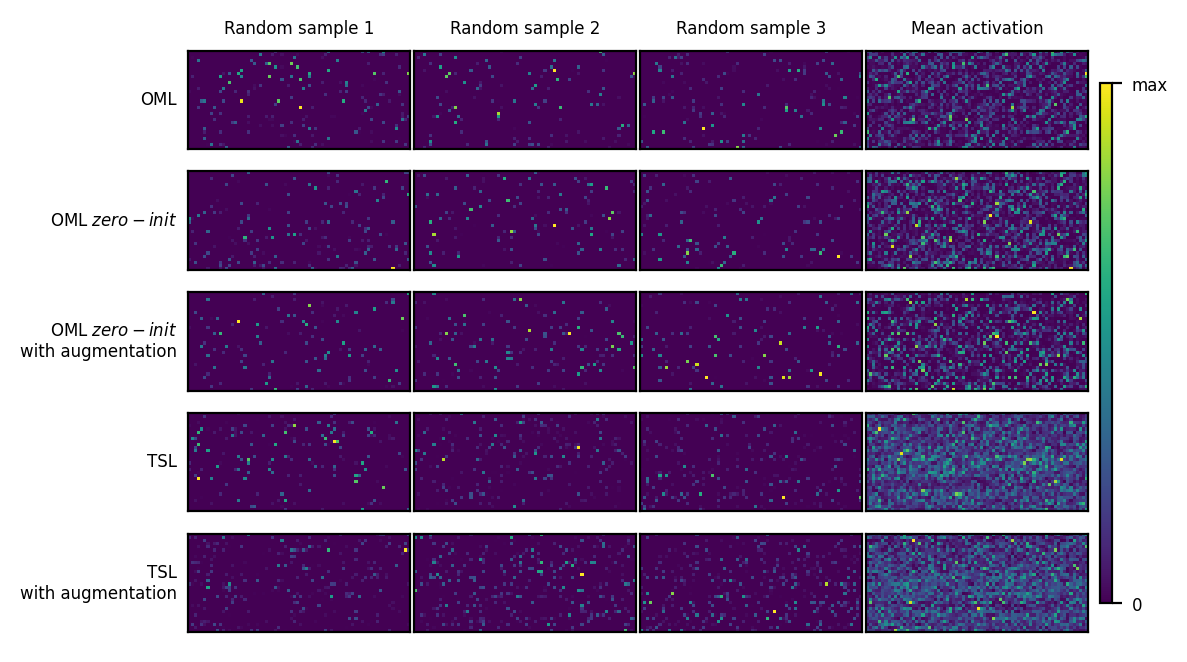

In [18]:
# fig, axes = plt.subplots(
#     ncols=4,
#     nrows=5,
# )
# (ax_reimpl, ax_reimpl_zero, ax_reimpl_zero_aug, ax_tsl, ax_tsl_aug) = axes[:, -1]

# # [(ax.set_axis_off()) for ax in axes.ravel()]
# [(ax.set_yticks([]), ax.set_xticks([])) for ax in axes.ravel()]


# for i, (all_reprs, s_reprs) in enumerate(
#     [
#         (oml_model_reprs_3, oml_sample_reprs_3),
#         (oml_zero_model_reprs_3, oml_zero_sample_reprs_3),
#         (oml_zero_model_aug_reprs_3, oml_zero_aug_sample_reprs_3),
#         (oml_sup_model_reprs_3, oml_sup_sample_reprs_3),
#         (oml_sup_model_aug_reprs_3, oml_sup_aug_sample_reprs_3),
#     ]
# ):
#     for j in range(3):
#         ax = axes[i, j]
#         s_repr = s_reprs[j]
#         # factor = all_reprs[0].max(0, keepdims=True)
#         # factor[factor == 0] = 1
#         factor = s_repr.max()
#         ax.imshow((s_repr / factor).reshape(32, 72))
#         # ax.imshow((s_repr > 0).astype(onp.int).reshape(32, 72))
#     im = axes[i, -1].imshow(get_act_map(all_reprs[0]))

# plt.subplots_adjust(
#     # bottom=0.1,
#     left=0.15,
#     # top=0.9,
#     # right=0.8,
#     wspace=0.02,
#     hspace=0.00,
# )

# cb_ax = fig.add_axes([0.91, 0.175, 0.01, 0.65])
# cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# # cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

# cbar.set_ticks([0, cbar.vmax])
# cbar.set_ticklabels(["0", "max"])
# cbar.ax.tick_params(labelsize=6)

# for ax, title in zip(
#     axes[:, 0],
#     [
#         "OML",
#         "OML $\it{zero-init}$",
#         "OML $\it{zero-init}$\nwith augmentation",
#         "TSL",
#         "TSL\nwith augmentation",
#     ],
# ):
#     ax.set_ylabel(
#         title,
#         rotation=0,
#         fontsize=6,
#         labelpad=4,
#         verticalalignment="center",
#         horizontalalignment="right",
#     )

# for ax, i in zip(axes[0, :], range(1, 4)):
#     ax.set_title(f"Random sample {i}", fontsize=6)

# axes[0, -1].set_title("Mean activation", fontsize=6)

# # plt.tight_layout()
# plt.savefig("oml_reprs_3.jpg", dpi=300)

In [35]:
sampled_images, sampled_labels = test_dataset_28[list(random_indexes)]
# outs = extract_embeddings_fn(sampled_images)
    
# anml_sample_reprs = (jax.device_get(anml_model(sampled_images)))
anml_zero_sample_reprs = (jax.device_get(anml_zero_model(sampled_images)))
anml_zero_aug_sample_reprs = (jax.device_get(anml_zero_model_aug(sampled_images)))

anml_sup_sample_reprs = (jax.device_get(anml_sup_model(sampled_images)))
# anml_sup_aug_sample_reprs = (jax.device_get(anml_sup_model_aug(sampled_images)))


# anml_sample_reprs_2 = (jax.device_get(anml_model_2(sampled_images)))
# anml_zero_sample_reprs_2 = (jax.device_get(anml_zero_model_2(sampled_images)))
# anml_zero_aug_sample_reprs_2 = (jax.device_get(anml_zero_model_aug_2(sampled_images)))

# anml_sup_sample_reprs_2 = (jax.device_get(anml_sup_model_2(sampled_images)))
# anml_sup_aug_sample_reprs_2 = (jax.device_get(anml_sup_model_aug_2(sampled_images)))


# anml_sample_reprs_3 = (jax.device_get(anml_model_3(sampled_images)))
# anml_zero_sample_reprs_3 = (jax.device_get(anml_zero_model_3(sampled_images)))
# anml_zero_aug_sample_reprs_3 = (jax.device_get(anml_zero_model_aug_3(sampled_images)))

# anml_sup_sample_reprs_3 = (jax.device_get(anml_sup_model_3(sampled_images)))
# anml_sup_aug_sample_reprs_3 = (jax.device_get(anml_sup_model_aug_3(sampled_images)))

In [31]:
def max_get_act_map(act):
    factor = act.max()
    return ((act / factor).reshape(32, 72))

In [32]:
from matplotlib.gridspec import GridSpec

In [33]:
def anml_get_act_map(reprs):
    maxes = reprs.max(0, keepdims=True)
    maxes[maxes == 0] = 1
    reprs = reprs / maxes
    return (reprs > 0.01).astype(onp.int).mean(0).reshape(32, 72)

# ANML Reprs

## Uno

In [29]:
anml_sup_model_reprs = extract_reprs(anml_sup_model, "anml")
# anml_sup_model_aug_reprs = extract_reprs(anml_sup_model_aug, "anml")

# anml_model_reprs = extract_reprs(anml_model, "anml")
anml_zero_model_reprs = extract_reprs(anml_zero_model, "anml")
anml_zero_model_aug_reprs = extract_reprs(anml_zero_model_aug, "anml")


# anml_sup_model_reprs_2 = extract_reprs(anml_sup_model_2, "anml")
# anml_sup_model_aug_reprs_2 = extract_reprs(anml_sup_model_aug_2, "anml")

# anml_model_reprs_2 = extract_reprs(anml_model_2, "anml")
# anml_zero_model_reprs_2 = extract_reprs(anml_zero_model_2, "anml")
# anml_zero_model_aug_reprs_2 = extract_reprs(anml_zero_model_aug_2, "anml")


# anml_sup_model_reprs_3 = extract_reprs(anml_sup_model_3, "anml")
# anml_sup_model_aug_reprs_3 = extract_reprs(anml_sup_model_aug_3, "anml")

# anml_model_reprs_3 = extract_reprs(anml_model_3, "anml")
# anml_zero_model_reprs_3 = extract_reprs(anml_zero_model_3, "anml")
# anml_zero_model_aug_reprs_3 = extract_reprs(anml_zero_model_aug_3, "anml")

### ANML

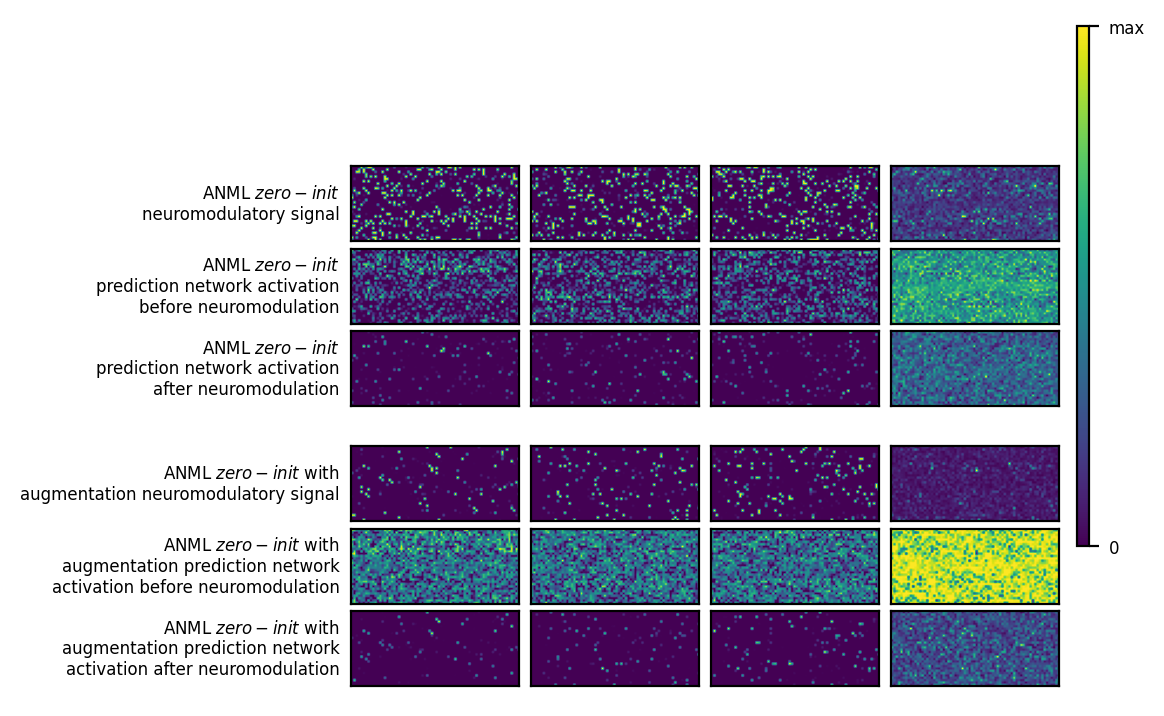

In [36]:
fig = plt.figure()

left = 0.25
right = 0.85
hspace = 0.1

# anml_model_reprs has (post, mask, pre), but anml_sample_reprs has (mask, pre, post)
# _anml_model_reprs = (anml_model_reprs[1], anml_model_reprs[2], anml_model_reprs[0]) 

# gs = GridSpec(3, 4, bottom=0.7, top=1.0, wspace=0.0, hspace=hspace, left=left, right=right)

# for i in range(3):
#     for j in range(4):
#         ax = fig.add_subplot(gs[i, j])
#         (ax.set_yticks([]), ax.set_xticks([]))
#         if j < 3:
#             ax.imshow(max_get_act_map(anml_sample_reprs[i][j]), vmin=0)
#             if i == 0:
#                 ax.set_title(
#                     f"Random sample {j + 1}", fontsize=6
#                 )
#         else:
#             if i == 0:
#                 ax.set_title(
#                     f"Mean activation", fontsize=6
#                 )
#             # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
#             ax.imshow(anml_get_act_map(_anml_model_reprs[i]), vmin=0)
            
#         if j == 0:
#             if (i == 0):
#                 ax.set_ylabel(
#                     "ANML\nneuromodulatory signal",
#                     rotation=0,
#                     fontsize=6,
#                     labelpad=4,
#                     verticalalignment="center",
#                     horizontalalignment="right",
#                     wrap=True,
#                 )
#             elif (i == 1):
#                 ax.set_ylabel(
#                     "ANML\nprediction network activation\nbefore neuromodulation",
#                     rotation=0,
#                     fontsize=6,
#                     labelpad=4,
#                     verticalalignment="center",
#                     horizontalalignment="right",
#                     wrap=True,
#                 )
#             elif (i == 2):
#                 ax.set_ylabel(
#                     "ANML\nprediction network activation\nafter neuromodulation",
#                     rotation=0,
#                     fontsize=6,
#                     labelpad=4,
#                     verticalalignment="center",
#                     horizontalalignment="right",
#                     wrap=True,
#                 )
            
_anml_zero_model_reprs = (anml_zero_model_reprs[1], anml_zero_model_reprs[2], anml_zero_model_reprs[0]) 
gs2 = GridSpec(3, 4, top=0.65, bottom=0.35, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs2[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_zero_sample_reprs[i][j]), vmin=0)
        else:
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_zero_model_reprs[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_zero_model_aug_reprs = (anml_zero_model_aug_reprs[1], anml_zero_model_aug_reprs[2], anml_zero_model_aug_reprs[0]) 
gs3 = GridSpec(3, 4, top=0.30, bottom=0.00, wspace=0.00001, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs3[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_zero_aug_sample_reprs[i][j]), vmin=0)
        else:
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_zero_model_aug_reprs[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation neuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation prediction network\nactivation before neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation prediction network\nactivation after neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )

cb_ax = fig.add_axes([0.86, 0.175, 0.01, 0.65])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)


### TSL

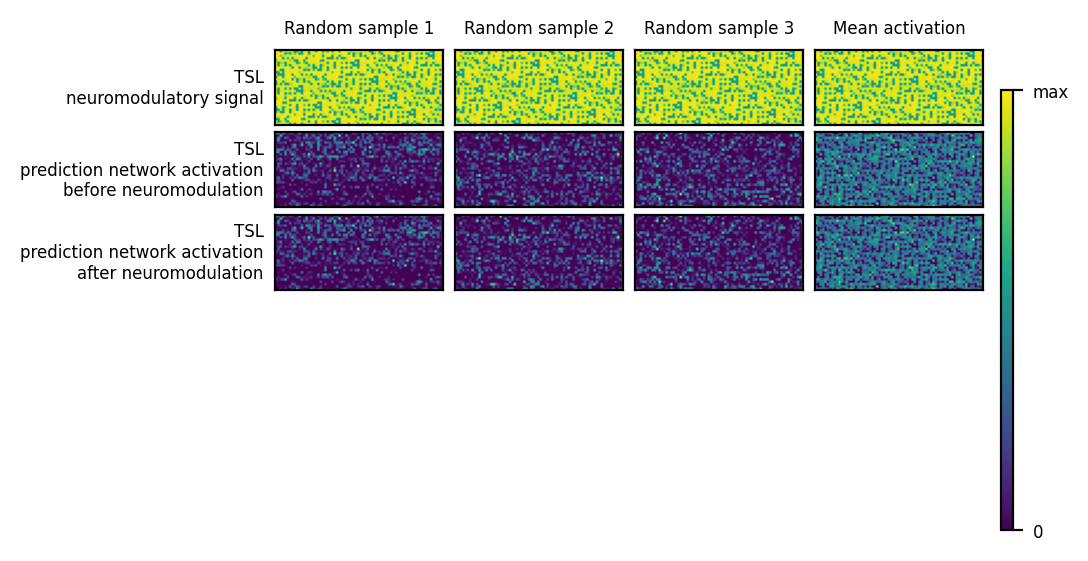

In [43]:
fig = plt.figure()

# anml_model_reprs has (post, mask, pre), but anml_sample_reprs has (mask, pre, post)
_anml_sup_model_reprs = (anml_sup_model_reprs[1], anml_sup_model_reprs[2], anml_sup_model_reprs[0]) 

left = 0.25
right = 0.85
hspace = 0.1
gs = GridSpec(3, 4, bottom=0.7, top=1.0, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sup_sample_reprs[i][j]), vmin=0)
            if i == 0:
                ax.set_title(
                    f"Random sample {j + 1}", fontsize=6
                )
        else:
            if i == 0:
                ax.set_title(
                    f"Mean activation", fontsize=6
                )
                ax.imshow(max_get_act_map(_anml_sup_model_reprs[i].mean(0)), vmin=0)
            else:
                ax.imshow((_anml_sup_model_reprs[i]).mean(0).reshape(32, 72), vmin=0)
            # ax.imshow(anml_get_act_map(_anml_sup_model_reprs[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "TSL\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "TSL\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "TSL\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
# _anml_sup_model_aug_reprs = (anml_sup_model_aug_reprs[1], anml_sup_model_aug_reprs[2], anml_sup_model_aug_reprs[0]) 
# gs2 = GridSpec(3, 4, top=0.65, bottom=0.35, wspace=0.0, hspace=hspace, left=left, right=right)

# for i in range(3):
#     for j in range(4):
#         ax = fig.add_subplot(gs2[i, j])
#         (ax.set_yticks([]), ax.set_xticks([]))
#         if j < 3:
#             ax.imshow(max_get_act_map(anml_sup_aug_sample_reprs[i][j]), vmin=0)
#         else:
#             if i == 0:
#                 ax.imshow(max_get_act_map(_anml_sup_model_aug_reprs[i].mean(0)), vmin=0)
#             else:
#                 ax.imshow((_anml_sup_model_aug_reprs[i]).mean(0).reshape(32, 72), vmin=0)
#             # ax.imshow(anml_get_act_map(_anml_sup_model_aug_reprs[i]), vmin=0)
            
#         if j == 0:
#             if (i == 0):
#                 ax.set_ylabel(
#                     "TSL with augmentation\nneuromodulatory signal",
#                     rotation=0,
#                     fontsize=6,
#                     labelpad=4,
#                     verticalalignment="center",
#                     horizontalalignment="right",
#                     wrap=True,
#                 )
#             elif (i == 1):
#                 ax.set_ylabel(
#                     "TSL with augmentation\nprediction network activation\nbefore neuromodulation",
#                     rotation=0,
#                     fontsize=6,
#                     labelpad=4,
#                     verticalalignment="center",
#                     horizontalalignment="right",
#                     wrap=True,
#                 )
#             elif (i == 2):
#                 ax.set_ylabel(
#                     "TSL with augmentation\nprediction network activation\nafter neuromodulation",
#                     rotation=0,
#                     fontsize=6,
#                     labelpad=4,
#                     verticalalignment="center",
#                     horizontalalignment="right",
#                     wrap=True,
#                 )


cb_ax = fig.add_axes([0.86, 0.4, 0.01, 0.55])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)


## Dos

In [23]:
anml_sup_model_reprs_2 = extract_reprs(anml_sup_model_2, "anml")
anml_sup_model_aug_reprs_2 = extract_reprs(anml_sup_model_aug_2, "anml")

anml_model_reprs_2 = extract_reprs(anml_model_2, "anml")
anml_zero_model_reprs_2 = extract_reprs(anml_zero_model_2, "anml")
anml_zero_model_aug_reprs_2 = extract_reprs(anml_zero_model_aug_2, "anml")


### ANML

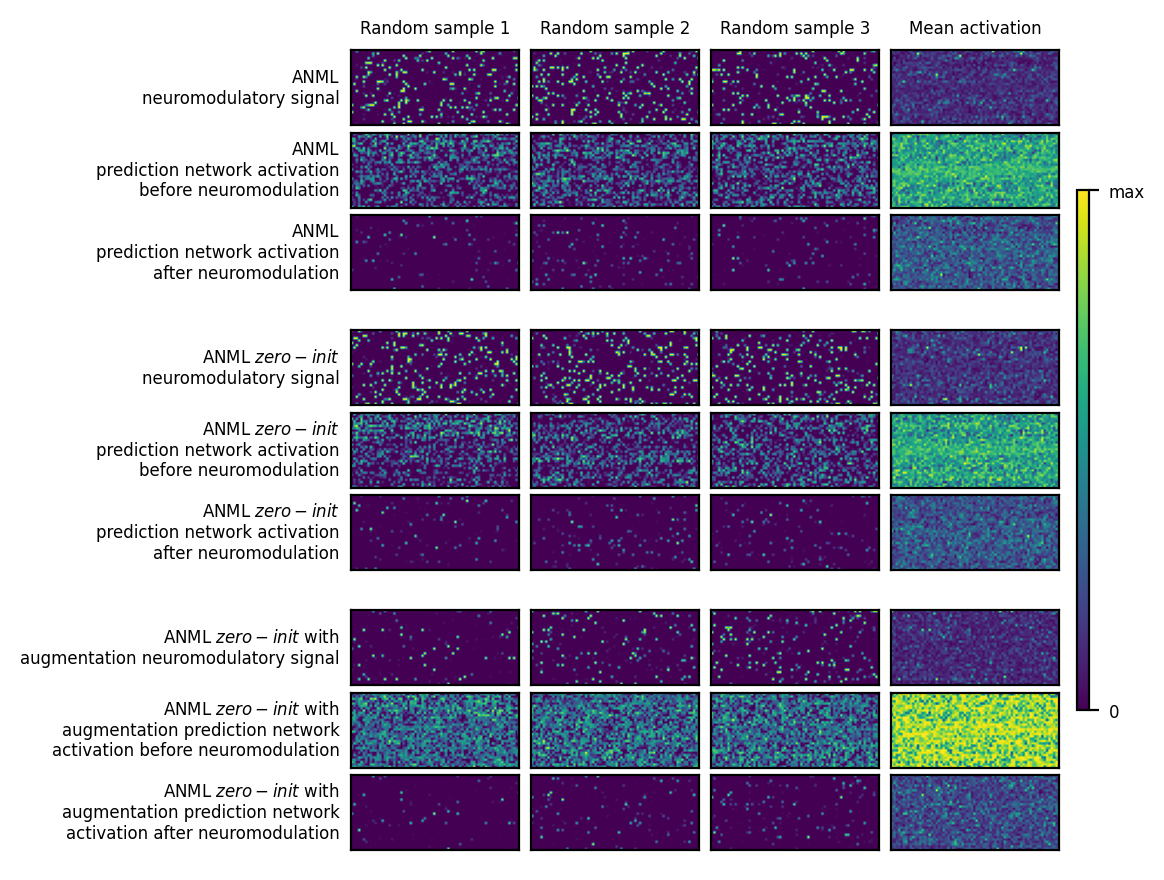

In [24]:
fig = plt.figure()

# anml_model_reprs has (post, mask, pre), but anml_sample_reprs has (mask, pre, post)
_anml_model_reprs_2 = (anml_model_reprs_2[1], anml_model_reprs_2[2], anml_model_reprs_2[0]) 


left = 0.25
right = 0.85
hspace = 0.1
gs = GridSpec(3, 4, bottom=0.7, top=1.0, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sample_reprs_2[i][j]), vmin=0)
            if i == 0:
                ax.set_title(
                    f"Random sample {j + 1}", fontsize=6
                )
        else:
            if i == 0:
                ax.set_title(
                    f"Mean activation", fontsize=6
                )
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_model_reprs_2[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_zero_model_reprs_2 = (anml_zero_model_reprs_2[1], anml_zero_model_reprs_2[2], anml_zero_model_reprs_2[0]) 
gs2 = GridSpec(3, 4, top=0.65, bottom=0.35, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs2[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_zero_sample_reprs_2[i][j]), vmin=0)
        else:
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_zero_model_reprs_2[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_zero_model_aug_reprs_2 = (anml_zero_model_aug_reprs_2[1], anml_zero_model_aug_reprs_2[2], anml_zero_model_aug_reprs_2[0]) 
gs3 = GridSpec(3, 4, top=0.30, bottom=0.00, wspace=0.00001, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs3[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_zero_aug_sample_reprs_2[i][j]), vmin=0)
        else:
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_zero_model_aug_reprs_2[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation neuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation prediction network\nactivation before neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation prediction network\nactivation after neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )

cb_ax = fig.add_axes([0.86, 0.175, 0.01, 0.65])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)


### TSL

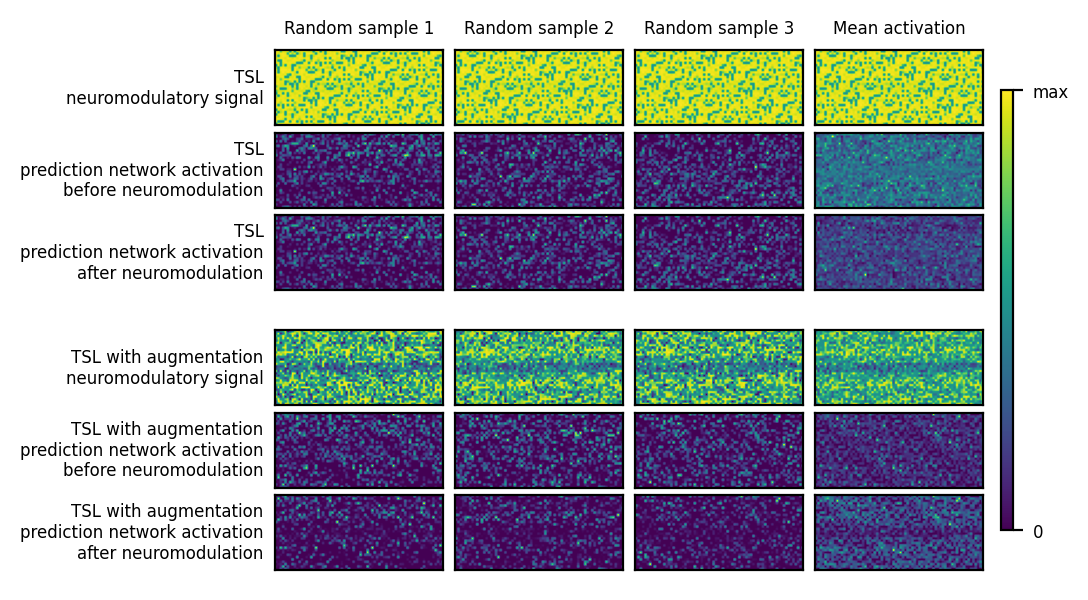

In [25]:
fig = plt.figure()

# anml_model_reprs has (post, mask, pre), but anml_sample_reprs has (mask, pre, post)
_anml_sup_model_reprs_2 = (anml_sup_model_reprs_2[1], anml_sup_model_reprs_2[2], anml_sup_model_reprs_2[0]) 

left = 0.25
right = 0.85
hspace = 0.1
gs = GridSpec(3, 4, bottom=0.7, top=1.0, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sup_sample_reprs_2[i][j]), vmin=0)
            if i == 0:
                ax.set_title(
                    f"Random sample {j + 1}", fontsize=6
                )
        else:
            if i == 0:
                ax.set_title(
                    f"Mean activation", fontsize=6
                )
                ax.imshow(max_get_act_map(_anml_sup_model_reprs_2[i].mean(0)), vmin=0)
            else:
                ax.imshow((_anml_model_reprs_2[i]).mean(0).reshape(32, 72), vmin=0)
            # ax.imshow(anml_get_act_map(_anml_sup_model_reprs_2[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "TSL\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "TSL\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "TSL\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_sup_model_aug_reprs_2 = (anml_sup_model_aug_reprs_2[1], anml_sup_model_aug_reprs_2[2], anml_sup_model_aug_reprs_2[0]) 
gs2 = GridSpec(3, 4, top=0.65, bottom=0.35, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs2[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sup_aug_sample_reprs_2[i][j]), vmin=0)
        else:
            if i == 0:
                ax.imshow(max_get_act_map(_anml_sup_model_aug_reprs_2[i].mean(0)), vmin=0)
            else:
                ax.imshow((_anml_sup_model_aug_reprs_2[i]).mean(0).reshape(32, 72), vmin=0)
            # ax.imshow(anml_get_act_map(_anml_sup_model_aug_reprs_2[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "TSL with augmentation\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "TSL with augmentation\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "TSL with augmentation\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )


cb_ax = fig.add_axes([0.86, 0.4, 0.01, 0.55])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)


## Tres

In [26]:
anml_sup_model_reprs_3 = extract_reprs(anml_sup_model_3, "anml")
anml_sup_model_aug_reprs_3 = extract_reprs(anml_sup_model_aug_3, "anml")

anml_model_reprs_3 = extract_reprs(anml_model_3, "anml")
anml_zero_model_reprs_3 = extract_reprs(anml_zero_model_3, "anml")
anml_zero_model_aug_reprs_3 = extract_reprs(anml_zero_model_aug_3, "anml")

### ANML

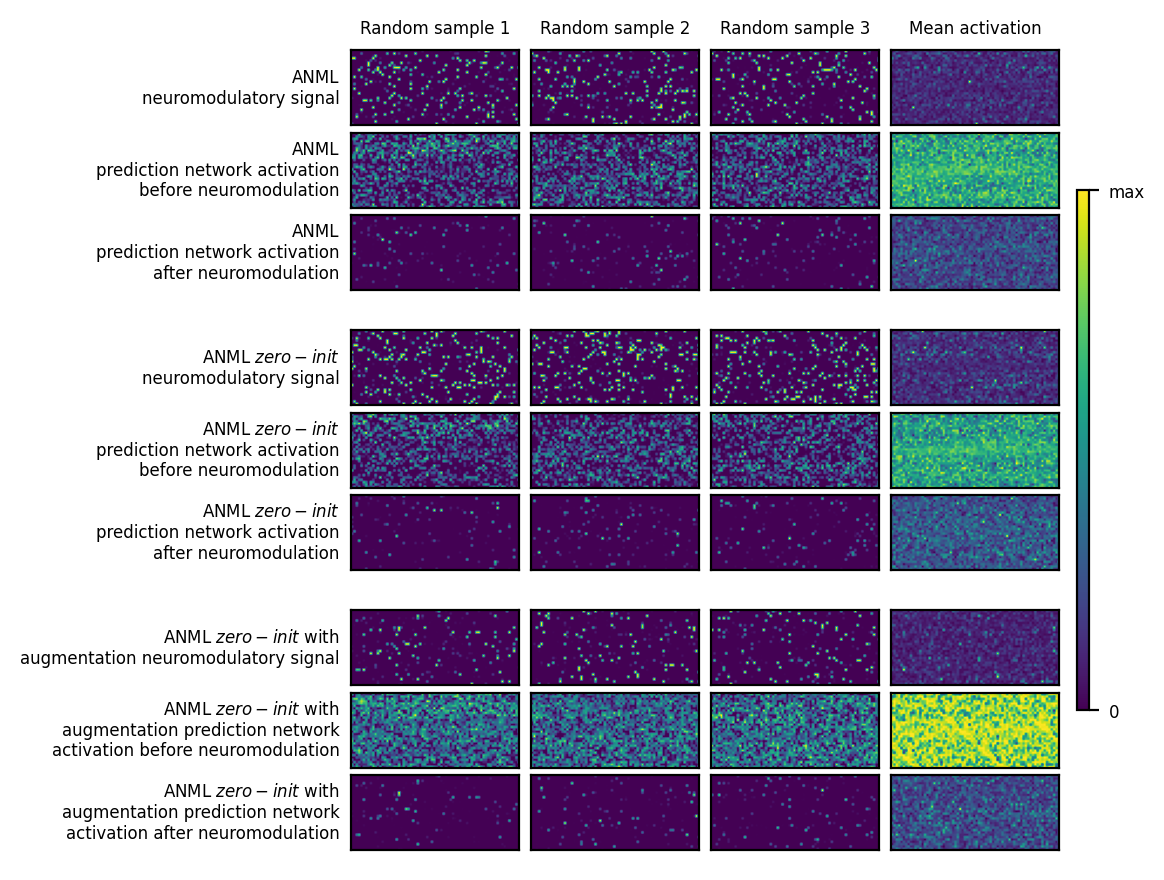

In [27]:
fig = plt.figure()

# anml_model_reprs has (post, mask, pre), but anml_sample_reprs has (mask, pre, post)
_anml_model_reprs_3 = (anml_model_reprs_3[1], anml_model_reprs_3[2], anml_model_reprs_3[0]) 


left = 0.25
right = 0.85
hspace = 0.1
gs = GridSpec(3, 4, bottom=0.7, top=1.0, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sample_reprs_3[i][j]), vmin=0)
            if i == 0:
                ax.set_title(
                    f"Random sample {j + 1}", fontsize=6
                )
        else:
            if i == 0:
                ax.set_title(
                    f"Mean activation", fontsize=6
                )
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_model_reprs_3[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_zero_model_reprs_3 = (anml_zero_model_reprs_3[1], anml_zero_model_reprs_3[2], anml_zero_model_reprs_3[0]) 
gs2 = GridSpec(3, 4, top=0.65, bottom=0.35, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs2[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_zero_sample_reprs_3[i][j]), vmin=0)
        else:
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_zero_model_reprs_3[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_zero_model_aug_reprs_3 = (anml_zero_model_aug_reprs_3[1], anml_zero_model_aug_reprs_3[2], anml_zero_model_aug_reprs_3[0]) 
gs3 = GridSpec(3, 4, top=0.30, bottom=0.00, wspace=0.00001, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs3[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_zero_aug_sample_reprs_3[i][j]), vmin=0)
        else:
            # ax.imshow((_anml_model_reprs[i]).mean(0).reshape(32, 72))
            ax.imshow(anml_get_act_map(_anml_zero_model_aug_reprs_3[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation neuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation prediction network\nactivation before neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "ANML $\it{zero-init}$ with\naugmentation prediction network\nactivation after neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )

cb_ax = fig.add_axes([0.86, 0.175, 0.01, 0.65])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)


### TSL

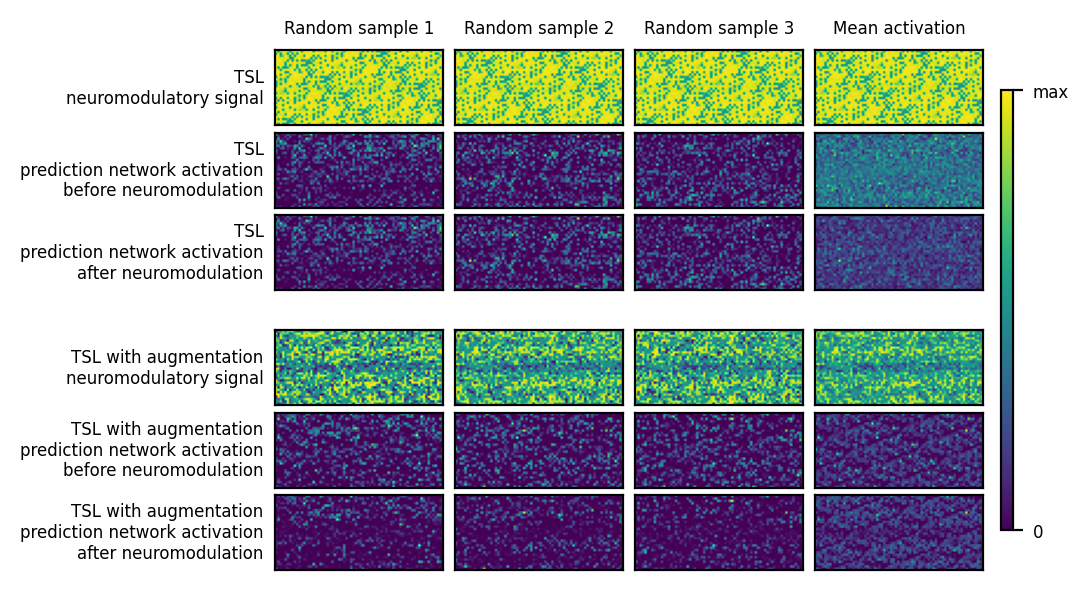

In [28]:
fig = plt.figure()

# anml_model_reprs has (post, mask, pre), but anml_sample_reprs has (mask, pre, post)
_anml_sup_model_reprs_3 = (anml_sup_model_reprs_3[1], anml_sup_model_reprs_3[2], anml_sup_model_reprs_3[0]) 

left = 0.25
right = 0.85
hspace = 0.1
gs = GridSpec(3, 4, bottom=0.7, top=1.0, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sup_sample_reprs_3[i][j]), vmin=0)
            if i == 0:
                ax.set_title(
                    f"Random sample {j + 1}", fontsize=6
                )
        else:
            if i == 0:
                ax.set_title(
                    f"Mean activation", fontsize=6
                )
                ax.imshow(max_get_act_map(_anml_sup_model_reprs_3[i].mean(0)), vmin=0)
            else:
                ax.imshow((_anml_model_reprs_3[i]).mean(0).reshape(32, 72), vmin=0)
            # ax.imshow(anml_get_act_map(_anml_sup_model_reprs_3[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "TSL\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "TSL\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "TSL\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            
_anml_sup_model_aug_reprs_3 = (anml_sup_model_aug_reprs_3[1], anml_sup_model_aug_reprs_3[2], anml_sup_model_aug_reprs_3[0]) 
gs2 = GridSpec(3, 4, top=0.65, bottom=0.35, wspace=0.0, hspace=hspace, left=left, right=right)

for i in range(3):
    for j in range(4):
        ax = fig.add_subplot(gs2[i, j])
        (ax.set_yticks([]), ax.set_xticks([]))
        if j < 3:
            ax.imshow(max_get_act_map(anml_sup_aug_sample_reprs_3[i][j]), vmin=0)
        else:
            if i == 0:
                ax.imshow(max_get_act_map(_anml_sup_model_aug_reprs_3[i].mean(0)), vmin=0)
            else:
                ax.imshow((_anml_sup_model_aug_reprs_3[i]).mean(0).reshape(32, 72), vmin=0)
            # ax.imshow(anml_get_act_map(_anml_sup_model_aug_reprs_3[i]), vmin=0)
            
        if j == 0:
            if (i == 0):
                ax.set_ylabel(
                    "TSL with augmentation\nneuromodulatory signal",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 1):
                ax.set_ylabel(
                    "TSL with augmentation\nprediction network activation\nbefore neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )
            elif (i == 2):
                ax.set_ylabel(
                    "TSL with augmentation\nprediction network activation\nafter neuromodulation",
                    rotation=0,
                    fontsize=6,
                    labelpad=4,
                    verticalalignment="center",
                    horizontalalignment="right",
                    wrap=True,
                )


cb_ax = fig.add_axes([0.86, 0.4, 0.01, 0.55])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)


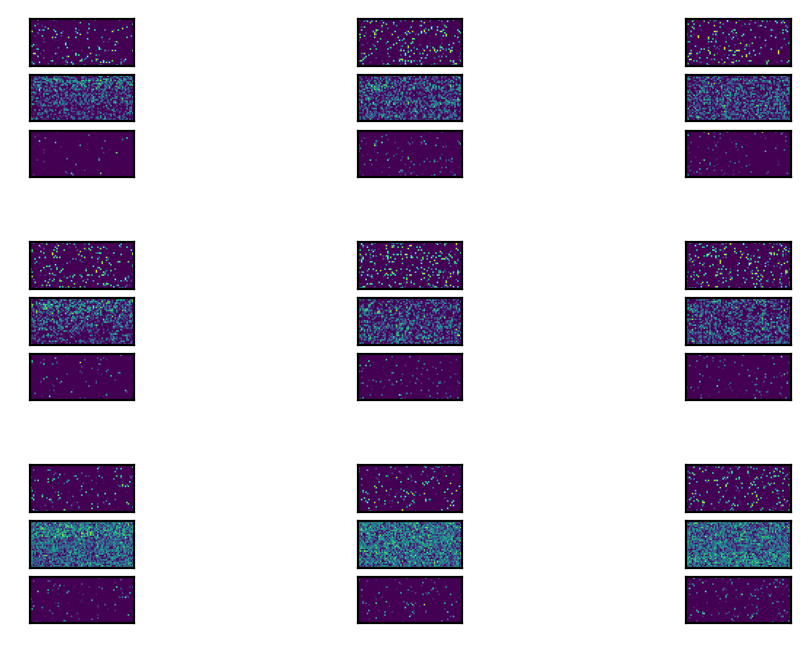

In [255]:
iis = list(range(9))
iis.insert(6, ".")
iis.insert(3, ".")

axd = plt.figure().subplot_mosaic(
    [[f"{i}{j}" if i != "." else "." for j in range(3)] for i in iis],
)

[(ax.set_yticks([]), ax.set_xticks([])) for ax in axd.values()]

for i, (all_reprs, s_reprs) in enumerate(
    [
        (anml_model_reprs, anml_sample_reprs),
        (anml_zero_model_reprs, anml_zero_sample_reprs),
        (anml_zero_model_aug_reprs, anml_zero_aug_sample_reprs),
        # (anml_sup_model_reprs, anml_sup_sample_reprs),
        # (anml_sup_model_aug_reprs, anml_sup_aug_sample_reprs),
    ]
):
    for nrow in range(3):
        for j in range(3):
            ax = axd[f"{i * 3 + nrow}{j}"]
            ax.imshow(max_get_act_map(s_reprs[nrow][j]))

# plt.subplots_adjust(
#     # bottom=0.1,
#     left=0.15,
#     # top=0.9,
#     # right=0.8,
#     wspace=0.05,
#     hspace=0.1,
# )

# identify_axes(axd, fontsize=5)

In [ ]:
# anml_sup_model_reprs_2 = extract_reprs(anml_sup_model_2, "anml")
# anml_sup_model_aug_reprs_2 = extract_reprs(anml_sup_model_aug_2, "anml")

# anml_model_reprs_2 = extract_reprs(anml_model_2, "anml")
# anml_zero_model_reprs_2 = extract_reprs(anml_zero_model_2, "anml")
# anml_zero_model_aug_reprs_2 = extract_reprs(anml_zero_model_aug_2, "anml")


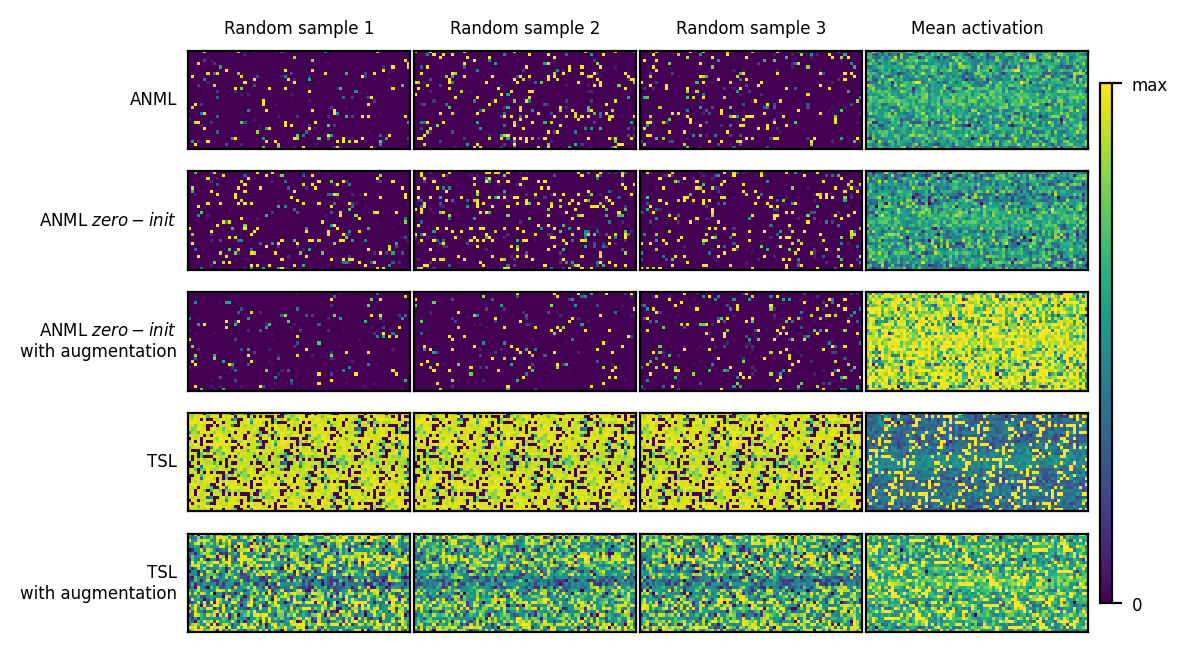

In [210]:
fig, axes = plt.subplots(
    ncols=4,
    nrows=5,
)
(ax_reimpl, ax_reimpl_zero, ax_reimpl_zero_aug, ax_tsl, ax_tsl_aug) = axes[:, -1]

# [(ax.set_axis_off()) for ax in axes.ravel()]
[(ax.set_yticks([]), ax.set_xticks([])) for ax in axes.ravel()]


for i, (all_reprs, s_reprs) in enumerate(
    [
        (anml_model_reprs, anml_sample_reprs),
        (anml_zero_model_reprs, anml_zero_sample_reprs),
        (anml_zero_model_aug_reprs, anml_zero_aug_sample_reprs),
        (anml_sup_model_reprs, anml_sup_sample_reprs),
        (anml_sup_model_aug_reprs, anml_sup_aug_sample_reprs),
    ]
):
    for j in range(3):
        ax = axes[i, j]
        s_repr = s_reprs[j]
        # factor = all_reprs[0].max(0, keepdims=True)
        # factor[factor == 0] = 1
        factor = s_repr.max()
        ax.imshow((s_repr / factor).reshape(32, 72))
        # ax.imshow((s_repr > 0).astype(onp.int).reshape(32, 72))
    im = axes[i, -1].imshow(get_act_map(all_reprs[0]))

plt.subplots_adjust(
    # bottom=0.1,
    left=0.15,
    # top=0.9,
    # right=0.8,
    wspace=0.02,
    hspace=0.00,
)

cb_ax = fig.add_axes([0.91, 0.175, 0.01, 0.65])
cbar = fig.colorbar(mpl.cm.ScalarMappable(), cax=cb_ax)
# cbar = fig.colorbar(im, ax=cb_ax, shrink=0.5)

cbar.set_ticks([0, cbar.vmax])
cbar.set_ticklabels(["0", "max"])
cbar.ax.tick_params(labelsize=6)

for ax, title in zip(
    axes[:, 0],
    [
        "ANML",
        "ANML $\it{zero-init}$",
        "ANML $\it{zero-init}$\nwith augmentation",
        "TSL",
        "TSL\nwith augmentation",
    ],
):
    ax.set_ylabel(
        title,
        rotation=0,
        fontsize=6,
        labelpad=4,
        verticalalignment="center",
        horizontalalignment="right",
    )

for ax, i in zip(axes[0, :], range(1, 4)):
    ax.set_title(f"Random sample {i}", fontsize=6)

axes[0, -1].set_title("Mean activation", fontsize=6)

# plt.tight_layout()
plt.savefig("oml_reprs.jpg", dpi=300)